In [430]:
import json
import traceback
import pandas as pd
import numpy as np
import subprocess
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

In [431]:
subprocess.run(['bash', 'fetch_log_file.sh'])

CompletedProcess(args=['bash', 'fetch_log_file.sh'], returncode=0)

In [432]:
df = pd.read_csv('log.txt', header=None)

In [433]:
df.columns = ['symbol', 'action', 'current_price', 'shares', 'limit_price']
for col in df:
    df[col] = df[col].str.replace('{|}', '').str.replace('"', '', regex=False).str.replace(f'{col}:', '', regex=False) 
df[['current_price', 'shares', 'limit_price']] = df[['current_price', 'shares', 'limit_price']].astype(float)

In [434]:
df

,symbol,action,current_price,shares,limit_price
0,TSLA,SELL,935.880,100.0,935.898000
1,TSLA,BUY,936.175,100.0,936.128125
2,TSLA,BUY,936.335,100.0,936.301250
3,TSLA,BUY,936.335,100.0,936.315714
4,TSLA,BUY,936.420,100.0,936.388571
...,...,...,...,...,...
2117,TSLA,BUY,978.920,100.0,978.866667
2118,TSLA,BUY,978.875,100.0,978.829167
2119,TSLA,BUY,978.870,100.0,978.825000
2120,TSLA,BUY,979.215,100.0,979.161250


In [435]:
df.loc[df['symbol'] == 'TSLA']

,symbol,action,current_price,shares,limit_price
0,TSLA,SELL,935.880,100.0,935.898000
1,TSLA,BUY,936.175,100.0,936.128125
2,TSLA,BUY,936.335,100.0,936.301250
3,TSLA,BUY,936.335,100.0,936.315714
4,TSLA,BUY,936.420,100.0,936.388571
...,...,...,...,...,...
2117,TSLA,BUY,978.920,100.0,978.866667
2118,TSLA,BUY,978.875,100.0,978.829167
2119,TSLA,BUY,978.870,100.0,978.825000
2120,TSLA,BUY,979.215,100.0,979.161250


In [436]:
def filter_events(symbol_events):
    filtered_events = []
    for i in range(len(symbol_events)):
        if symbol_events[i]['action'] == 'BUY':
            break
    if i == len(symbol_events):
        raise Exception
    filtered_events = [symbol_events[i]]
    for j in range(i, len(symbol_events)):
        if symbol_events[j]['action'] != filtered_events[-1]['action']:
            filtered_events.append(symbol_events[j])
    return filtered_events

def get_trade_gains(symbol):
    try:
        symbol_events = df.loc[df['symbol'] == symbol].to_dict(orient='records')
        symbol_events = filter_events(symbol_events)
        return [
            symbol_events[i]['limit_price'] - symbol_events[i - 1]['limit_price'] 
            for i in range(1, len(symbol_events))
        ]
    except Exception as e:
        return []

In [437]:
net_profit = 0
symbol_stats = {}
symbols = df['symbol'].unique()
for symbol in symbols:
    symbol_gains = get_trade_gains(symbol)
    symbol_net_profit = np.sum(symbol_gains)
    symbol_wins = [x for x in symbol_gains if x > 0]
    symbol_losses = [x for x in symbol_gains if x < 0]
    symbol_max_profit = np.max(symbol_wins or [0])
    symbol_max_loss = np.min(symbol_losses or [0])
    symbol_stats[symbol] = {
        'gains': symbol_gains,
        'net_profit': symbol_net_profit,
        'wins': symbol_wins,
        'losses': symbol_losses,
        'max_profit': symbol_max_profit,
        'max_loss': symbol_max_loss
    }
    net_profit += symbol_net_profit
    print(f'Net profit: ${net_profit:.2f}', end='\r')

wins = sum([len(x["wins"]) for x in symbol_stats.values()])
losses = sum([len(x["losses"]) for x in symbol_stats.values()])
print(f'Net profit: ${net_profit:.2f}')
print(f'Wins: {wins}')
print(f'Losses: {losses}')
print(f'Win Rate: {100*wins/(wins + losses):.2f}%')
all_gains = sum([x['gains'] for x in symbol_stats.values()], [])
print()
print(f'Mean gain: ${np.mean(all_gains)}')
print(f'Gains std: ${np.std(all_gains)}')
print(f'Max gain: ${np.max(all_gains)}')
print(f'Min gain: ${np.min(all_gains)}')
print(f'Skew: {skew(all_gains)}')
print(f'Kurtosis: {kurtosis(all_gains)}')

Net profit: $42.86
Wins: 236
Losses: 224
Win Rate: 51.30%

Mean gain: $0.09316440217391311
Gains std: $1.3173691336250655
Max gain: $14.153376623376516
Min gain: $-5.633833333333087
Skew: 3.6661711374230053
Kurtosis: 38.63478969897319


(array([  2.,   0.,   2.,   3.,  14.,  32., 131., 191.,  55.,  20.,   4.,
          2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.]),
 array([-5.63383333, -4.84234494, -4.05085654, -3.25936814, -2.46787974,
        -1.67639134, -0.88490294, -0.09341455,  0.69807385,  1.48956225,
         2.28105065,  3.07253905,  3.86402745,  4.65551584,  5.44700424,
         6.23849264,  7.02998104,  7.82146944,  8.61295784,  9.40444623,
        10.19593463, 10.98742303, 11.77891143, 12.57039983, 13.36188823,
        14.15337662]),
 <a list of 25 Patch objects>)

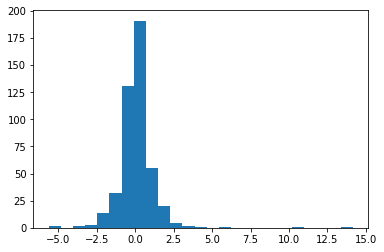

In [438]:
plt.hist(all_gains, bins=25)